# Preparation

Load prerequisities and prepare data

In [ ]:
# Import needs
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install catboost --quiet
import catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
# Load data from drive
def load_data(link, index= None):
  """
  Download data from link id and setting index for dataset index
  """

  # Download data from gdrive
  meta_url = 'https://drive.google.com/uc?export=download&confirm=pbef&id='
  url = meta_url + link
  output = 'data.csv'
  gdown.download(url, output, quiet=True)
  data = pd.read_csv(output)

  # Setting index for dataset
  if index:
    data.set_index(index, inplace=True)

  return data

In [ ]:
train = load_data('1mAjLdRmwiyKWQXSAwFIJ7y_fMLC76GLZ')
test = load_data('1CdGte3RRy-Y0X2ZATOiDkrJJZu7KPJbR')

In [ ]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [ ]:
target = (train['hotel_id']!='None').astype(int)

In [ ]:
train.drop(['hotel_id'], axis=1, inplace=True)

In [ ]:
train.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,visited_city,log_transaction
0,42d466e5a33c6e4fd34006800effce4a,36d46513e25cce91f1af22e211332edb,1638.0,M,trip,ECONOMY,3211338.0,NO,2.0,74c5549aa99d55280a896ea50068a211,CGK - DPS,"'['Medan', 'Bali', 'Jakarta']'","'[9628704.09, 3211338.0]'"
1,5afc7174bc4a75cc0fa9077d604dc63d,d5d522ef4b637c4a7db79a1cc52bbf03,452.0,F,trip,ECONOMY,1193309.0,YES,1.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,"'['Bali', 'Jakarta', 'Medan']'","'[1828399.48, 1193309.0]'"
2,4562a667823b24909c36a08368e8c21a,d4447f6db23b387ee5e7804933c471b9,403.0,M,trip,ECONOMY,6594718.0,NO,2.0,74c5549aa99d55280a896ea50068a211,CGK - DPS,"'['Jakarta', 'Medan', 'Bali']'","'[5533979.1, 7882490.82, 3538015.0, 6594718.0]'"
3,a70622278060d8a3328c9607fd49b010,c7ce01a948b92049a01f3ebd8f797812,738.0,F,trip,ECONOMY,1936740.0,YES,1.0,e35de6a36d385711a660c72c0286154a,CGK - DPS,"'['Surabaya', 'Medan', 'Bali', 'Jakarta', 'Ace...","'[4849977.72, 9688620.93, 9070698.09, 7519349...."
4,d64a90a618202a5e8b25d8539377f3ca,7b86fdc01012c58885f4b361a7a043f9,607.0,M,trip,ECONOMY,5497908.0,NO,3.0,ad5bef60d81ea077018f4d50b813153a,CGK - DPS,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."


# Baseline

Creating baseline model

In [ ]:
continous_train = train.select_dtypes(exclude='object')
categorical_train = train.select_dtypes(include='object')
continous_test = test.select_dtypes(exclude='object')
categorical_test = test.select_dtypes(include='object')

In [ ]:
print(categorical_train.nunique())
print()
print(categorical_test.nunique())

account_id         35372
order_id           47178
gender                 3
trip                   3
service_class          2
is_tx_promo            2
airlines_name          8
route                  1
visited_city           8
log_transaction    47178
dtype: int64

account_id         49567
order_id           70768
gender                 3
trip                   3
service_class          2
is_tx_promo            2
airlines_name          8
route                  1
visited_city           8
log_transaction    70768
dtype: int64


There are several account id that intersects from train and test

In [ ]:
unique_id = set(test.account_id) & set(train.account_id) 
same_id = test[test['account_id'].isin(unique_id)]
print(f"{round(same_id.shape[0]/test.shape[0]*100,2)}% test account id is in train account id")

36.26% test account id is in train account id


Drop the columns with many unique value (exclude account id)

In [ ]:
sum_unique_train = categorical_train.nunique()
sum_unique_test = categorical_test.nunique()
train_drop = train.drop(sum_unique_train[(sum_unique_train > 40000) | (sum_unique_train==1)].index, axis=1)
test_drop = test.drop(sum_unique_test[(sum_unique_test > 50000) | (sum_unique_test==1)].index, axis=1)

In [ ]:
continous_col = train_drop.select_dtypes(exclude='object').columns
categorical_col = train_drop.select_dtypes(include='object').columns

Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
train_norm = pd.concat([pd.DataFrame(std.fit_transform(train_drop[continous_col]), 
                                     columns = continous_col),train_drop[categorical_col]], axis=1)
test_norm = pd.concat([pd.DataFrame(std.transform(test_drop[continous_col]), 
                                     columns = continous_col),test_drop[categorical_col]], axis=1)

Train model with catboost

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val, target_train, target_val = train_test_split(train_norm, target, 
                                                                  test_size=0.15, random_state=42)

In [ ]:
from catboost import CatBoostClassifier
cbc_model = CatBoostClassifier(random_state=1, silent=True, cat_features=categorical_col.values)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

score = cross_val_score(cbc_model, train_norm, target, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1)
score.mean()

0.596267618064008

# Preprocess visited city

Cancelled

In [ ]:
# tmp = train['visited_city']
# zero = tmp[target==0]
# one = tmp[target==1]

# for i in tmp.unique():
#     print(f"{i} --- one is {round(one[one==i].count()/(zero[zero==i].count()+one[one==i].count()),4)*100}%")

'['Medan', 'Bali', 'Jakarta']' --- one is 6.529999999999999%
'['Bali', 'Jakarta', 'Medan']' --- one is 5.54%
'['Jakarta', 'Medan', 'Bali']' --- one is 5.0%
'['Surabaya', 'Medan', 'Bali', 'Jakarta', 'Aceh']' --- one is 5.5%
'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'Semarang']' --- one is 5.81%
'['Semarang', 'Jakarta', 'Medan', 'Bali']' --- one is 5.3%
'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']' --- one is 4.91%
'['Manado', 'Medan', 'Bali', 'Jakarta']' --- one is 4.99%


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# import re

# def clean_visited_city(x):
#     text = " ".join(re.split('\W+',x)).strip()
#     return text

# train['clean_visited_city'] = train['visited_city'].apply(lambda x : clean_visited_city(x))

In [ ]:
# tfidf = TfidfVectorizer()
# X_tfidf = tfidf.fit_transform(train['clean_visited_city'])
# df_tfidf = pd.DataFrame(X_tfidf.toarray())

# count_vect = CountVectorizer()
# X_countvect = count_vect.fit_transform(train['clean_visited_city'])
# df_countvect = pd.DataFrame(X_countvect.toarray())

In [ ]:
# from sklearn.decomposition import PCA

# principal_tfidf = PCA()
# principal_tfidf.fit(df_tfidf)
# print(np.round((principal_tfidf.explained_variance_ratio_*100).astype(float),3))

# principal_countvect = PCA()
# principal_countvect.fit(df_countvect)
# print(np.round((principal_countvect.explained_variance_ratio_*100).astype(float),3))

[5.8671e+01 2.3069e+01 9.6300e+00 8.5840e+00 4.6000e-02 0.0000e+00
 0.0000e+00 0.0000e+00]
[63.067 22.813  8.997  5.122  0.     0.     0.     0.   ]


In [ ]:
# principal_tfidf_final = PCA(n_components=4)
# X_tfidf_pca = pd.DataFrame(principal_tfidf_final.fit_transform(df_tfidf))

# principal_countvect = PCA(n_components=4)
# X_countvect_pca = pd.DataFrame(principal_countvect.fit_transform(df_countvect))

In [ ]:
# X_tfidf_pca.columns = "tfidf_visited_" + X_tfidf_pca.columns.astype(str) 
# X_countvect_pca.columns = "countvect_visited_" + X_countvect_pca.columns.astype(str) 

# train_1 = pd.concat([train_norm, X_tfidf_pca], axis=1).drop('visited_city', axis=1)
# train_2 = pd.concat([train_norm, X_countvect_pca], axis=1).drop('visited_city', axis=1)

# categorical_col = train_1.select_dtypes(include='object').columns

In [ ]:
# cbc_model = CatBoostClassifier(random_state=1, silent=True, cat_features=categorical_col.values)
# score = cross_val_score(cbc_model, train_1, target, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1)
# score.mean()

0.595117058003928

In [ ]:
# score = cross_val_score(cbc_model, train_2, target, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1)
# score.mean()

0.5933135229582435

# Preprocess transaction

Clean the log transaction feature and group price per 10000

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

def clean_log_transaction(data):
    tmp = data.apply(lambda x : " ".join(re.split("[\[\],']",x)).strip())
    tmp = tmp.apply(lambda x: x.split(" "))
    tmp = tmp.apply(lambda x: [i for i in x if i != ""])
    tmp = tmp.apply(lambda x: " ".join(np.round(np.array(x).astype(float)).astype(int).astype(str)))
    tmp = tmp.apply(lambda x: np.array(x.split()).astype(int))
    tmp = tmp//10000
    return tmp

train_norm['clean_log_transaction'] = clean_log_transaction(train['log_transaction'])
test_norm['clean_log_transaction'] = clean_log_transaction(test['log_transaction'])

In [ ]:
pd.concat([train_norm['clean_log_transaction'], train['log_transaction']], axis=1)

,clean_log_transaction,log_transaction
0,"[962, 321]","'[9628704.09, 3211338.0]'"
1,"[182, 119]","'[1828399.48, 1193309.0]'"
2,"[553, 788, 353, 659]","'[5533979.1, 7882490.82, 3538015.0, 6594718.0]'"
3,"[484, 968, 907, 751, 819, 215, 240, 134, 123, ...","'[4849977.72, 9688620.93, 9070698.09, 7519349...."
4,"[55, 242, 739, 793, 170, 566, 227, 327, 264, 8...","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."
...,...,...
47173,"[914, 251, 70, 610]","'[9146378.67, 2512956.75, 703891.74, 6104280.0]'"
47174,"[89, 992, 364, 182, 89, 178, 627, 104, 627, 12...","'[894966.08, 9924135.02, 3647020.0, 1823510.0,..."
47175,"[999, 836, 691, 476, 326, 87, 90, 89, 90, 90, ...","'[9996684.38, 8363709.16, 6918937.1, 4767680.0..."
47176,"[55, 242, 739, 793, 170, 566, 227, 327, 264, 8...","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."


Check the distribution and the unique of price group

In [ ]:
price = []
for i in train_norm['clean_log_transaction']:
  for j in i:
    price.append(j)
price = np.array(price)

In [ ]:
len(set(price))

1664

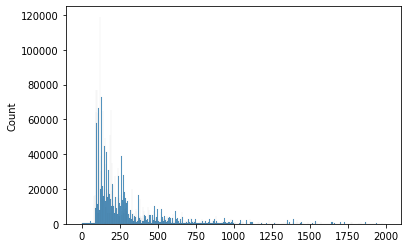

In [ ]:
sns.histplot(price[price<2000])

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_norm['clean_log_transaction'].astype(str))
# transaction_train_seq = tokenizer.texts_to_sequences(train_norm['clean_log_transaction'].astype(str))
# transaction_test_seq = tokenizer.texts_to_sequences(test_norm['clean_log_transaction'].astype(str))

Check the length of each transaction and the distribution

In [ ]:
length_transaction = []
for i in range(np.array(train_norm['clean_log_transaction']).shape[0]):
    tmp = np.array(train_norm['clean_log_transaction'][i]).shape[0]
    length_transaction.append(tmp)
length_transaction = np.array(length_transaction)

In [ ]:
np.mean(length_transaction)

10.832421891559624

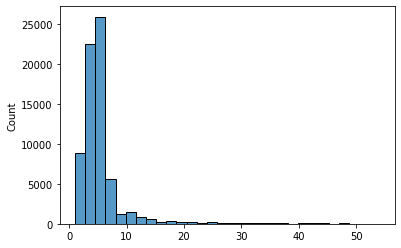

In [ ]:
sns.histplot(length_transaction[length_transaction<55], bins=30)

Padding on log transaction feature

In [ ]:
transaction_train_padded = pad_sequences(train_norm['clean_log_transaction'],20,
                                         padding='post',
                                         truncating='post')
transaction_test_padded = pad_sequences(test_norm['clean_log_transaction'],20,
                                        padding='post',
                                        truncating='post')

Reduce the feature dimensionality that is made by clean log transaction

In [ ]:
from sklearn.decomposition import PCA
principal_padded = PCA()
principal_padded.fit(transaction_train_padded)
print(np.round((principal_padded.explained_variance_ratio_*100).astype(float),3)[:2].sum())

45.074


In [ ]:
principal_padded = PCA(n_components=2)
X_padded_pca_train = pd.DataFrame(principal_padded.fit_transform(transaction_train_padded))
X_padded_pca_test = pd.DataFrame(principal_padded.transform(transaction_test_padded))

X_padded_pca_train.columns = "padded_trans_" + X_padded_pca_train.columns.astype(str) 
X_padded_pca_test.columns = "padded_trans_" + X_padded_pca_test.columns.astype(str) 

train_norm = pd.concat([train_norm, X_padded_pca_train], axis=1)
test_norm = pd.concat([test_norm, X_padded_pca_test], axis=1)

In [ ]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def F1(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# # Callback function
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import TensorBoard

# # Callback for plotting loss
# tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=1,
#                             write_graph=True, write_images=True)

# # Callback for reducing learning rate
# reduce_lr = ReduceLROnPlateau(
#     monitor = 'val_loss', 
#     factor = 0.5,   
#     patience = 15, 
#     verbose = 1)

In [ ]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy='minority')
# oversampled_train, oversampled_target = sm.fit_resample(transaction_train_padded, target)

# import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index), 
#                               input_length = 55,
#                               output_dim = 100),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[F1])

# with tf.device('/device:GPU:0'):
#   history = model.fit(oversampled_train, oversampled_target, epochs=30, batch_size=1024,
#                       validation_split=0.2, verbose=2,
#                       callbacks=[reduce_lr, tensor_board])

Epoch 1/30
70/70 - 4s - loss: 0.6449 - F1: 0.0959 - val_loss: 0.8499 - val_F1: 0.5779 - lr: 0.0010 - 4s/epoch - 61ms/step
Epoch 2/30
70/70 - 2s - loss: 0.5722 - F1: 0.5118 - val_loss: 0.8054 - val_F1: 0.5804 - lr: 0.0010 - 2s/epoch - 23ms/step
Epoch 3/30
70/70 - 2s - loss: 0.5509 - F1: 0.5502 - val_loss: 0.7811 - val_F1: 0.6343 - lr: 0.0010 - 2s/epoch - 22ms/step
Epoch 4/30
70/70 - 1s - loss: 0.5256 - F1: 0.5940 - val_loss: 0.8490 - val_F1: 0.5983 - lr: 0.0010 - 1s/epoch - 18ms/step
Epoch 5/30
70/70 - 1s - loss: 0.5047 - F1: 0.6186 - val_loss: 0.7692 - val_F1: 0.6807 - lr: 0.0010 - 1s/epoch - 15ms/step
Epoch 6/30
70/70 - 1s - loss: 0.4847 - F1: 0.6410 - val_loss: 0.8134 - val_F1: 0.6549 - lr: 0.0010 - 1s/epoch - 15ms/step
Epoch 7/30
70/70 - 1s - loss: 0.4658 - F1: 0.6554 - val_loss: 0.8832 - val_F1: 0.6182 - lr: 0.0010 - 1s/epoch - 15ms/step
Epoch 8/30
70/70 - 1s - loss: 0.4487 - F1: 0.6746 - val_loss: 0.8748 - val_F1: 0.6360 - lr: 0.0010 - 1s/epoch - 16ms/step
Epoch 9/30
70/70 - 1s - 

In [ ]:
# model.evaluate(transaction_train_padded, target)

1475/1475 [==============================] - 5s 3ms/step - loss: 0.0747 - F1: 0.6837


[0.07474001497030258, 0.6837426424026489]

In [ ]:
# train_norm['vectorized_transaction'] = model.predict(transaction_train_padded)
# test_norm['vectorized_transaction'] = model.predict(transaction_test_padded)

# Modelling

Create sum and length transaction feature

In [ ]:
train_norm['sum_transaction'] = train_norm['clean_log_transaction'].apply(lambda x: x.sum())
test_norm['sum_transaction'] = test_norm['clean_log_transaction'].apply(lambda x: x.sum())

In [ ]:
train_norm['len_transaction'] = train_norm['clean_log_transaction'].apply(lambda x: len(x))
test_norm['len_transaction'] = test_norm['clean_log_transaction'].apply(lambda x: len(x))

In [ ]:
train_norm.drop("clean_log_transaction", axis=1, inplace=True)
test_norm.drop("clean_log_transaction", axis=1, inplace=True)

train_norm.drop("vectorized_transaction", axis=1, inplace=True)
test_norm.drop("vectorized_transaction", axis=1, inplace=True)

Scale and train catboost model

In [ ]:
from sklearn.preprocessing import StandardScaler

sd = StandardScaler()
train_norm.iloc[:,-4:] = sd.fit_transform(train_norm.iloc[:,-4:]) 
test_norm.iloc[:,-4:] = sd.transform(test_norm.iloc[:,-4:]) 

In [ ]:
categorical_col = train_norm.select_dtypes("object").columns

In [ ]:
cbc_model = CatBoostClassifier(random_state=1, silent=True, cat_features=categorical_col.values)

In [ ]:
score = cross_val_score(cbc_model, train_norm, target, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1)
score.mean()

0.5948664116490079

In [ ]:
cbc_model.fit(train_norm, target)

In [ ]:
pd.DataFrame({'feature_importance': cbc_model.feature_importances_, 
              'feature_names': train_norm.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
0,12.791046,member_duration_days
5,11.975036,trip
1,10.335634,price
3,10.230059,account_id
8,8.873367,airlines_name
11,7.924534,padded_trans_1
12,7.491934,sum_transaction
13,7.244323,len_transaction
10,7.179583,padded_trans_0
7,5.401961,is_tx_promo


In [ ]:
pred = cbc_model.predict(test_norm)

In [ ]:
pd.Series(pred).value_counts()

0    69894
1      874
dtype: int64

In [ ]:
submission = pd.DataFrame({'order_id':test.order_id,
                           'is_cross_sell':pred})
submission.to_csv('sub.csv', index=False)
submission.head()

,order_id,is_cross_sell
0,02efb2c726c1e8d4f4864a9b3caa8e6b,0
1,eaad55e145547cc9e66e99c46632c208,0
2,a6b998a7d55e3b83481f4b87f209a127,0
3,b8a015f14e20263fe4114f7ae7c60f00,0
4,ea7285763494be096bde7ca1b97c9075,0


# Tuning

Hyperparameter tuning

In [ ]:
pip install optuna --quiet

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 7.7 MB/s 
     |████████████████████████████████| 210 kB 44.8 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 146 kB 44.9 MB/s 
     |████████████████████████████████| 112 kB 45.1 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val, target_train, target_val = train_test_split(train_norm, target, 
                                                                  test_size=0.15, random_state=42)

In [ ]:
import optuna

from sklearn.metrics import f1_score
from typing import Any
from typing import Optional

from catboost import CatBoostClassifier

from sklearn.base import ClassifierMixin


class CatBoostPruningCallback(object):

    def __init__(
        self, trial: optuna.trial.Trial, metric: str, eval_set_index: Optional[int] = None
    ) -> None:
        default_valid_name = "validation"
        self._trial = trial
        self._metric = metric
        if eval_set_index is None:
            self._valid_name = default_valid_name
        else:
            self._valid_name = default_valid_name + "_" + str(eval_set_index)
        self._pruned = False
        self._message = ""

    def after_iteration(self, info: Any) -> bool:
        step = info.iteration - 1
        if self._valid_name not in info.metrics:
            raise ValueError(
                'The entry associated with the validation name "{}" '
                "is not found in the evaluation result list {}.".format(self._valid_name, info)
            )
        metrics = info.metrics[self._valid_name]
        if self._metric not in metrics:
            raise ValueError(
                'The entry associated with the metric name "{}" '
                "is not found in the evaluation result list {}.".format(self._metric, info)
            )
        current_score = metrics[self._metric][-1]
        self._trial.report(current_score, step=step)
        if self._trial.should_prune():
            self._message = "Trial was pruned at iteration {}.".format(step)
            self._pruned = True
            return False
        return True

    def check_pruned(self) -> None:
        """Raise :class:`optuna.TrialPruned` manually if the CatBoost optimization is pruned."""
        if self._pruned:
            raise optuna.TrialPruned(self._message)


def objective(trial: optuna.Trial) -> float:
    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "depth": trial.suggest_int("depth", 4, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),
        "scale_pos_weight":trial.suggest_float("scale_pos_weight", 2,5),
        "eval_metric": "Accuracy"
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    
    gbm.fit(
        data_train,target_train,
        eval_set=[(data_val, target_val)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
        cat_features=categorical_col.values
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(data_val)
    score = f1_score(target_val, preds, average="macro")

    return score

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=150, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-05-16 14:58:06,554] A new study created in memory with name: no-name-a0cc5c1a-92ce-4cff-b530-355d44cb4a4b
[I 2022-05-16 14:58:18,077] Trial 0 finished with value: 0.6050825085418811 and parameters: {'colsample_bylevel': 0.06950332873508513, 'l2_leaf_reg': 0.040744199819470334, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 2, 'scale_pos_weight': 3.277708203859085}. Best is trial 0 with value: 0.6050825085418811.
[I 2022-05-16 14:58:21,261] Trial 1 finished with value: 0.4862058951648032 and parameters: {'colsample_bylevel': 0.046819162908042576, 'l2_leaf_reg': 0.08465184967414692, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 19, 'one_hot_max_size': 2, 'scale_pos_weight': 4.554647882573268}. Best is trial 0 with value: 0.6050825085418811.
[I 2022-05-16 14:58:24,080] Trial 2 finished with value: 0.4862058951648032 and parameters: {'colsample_bylevel': 0.026938012211736955, 'l2_leaf

Number of finished trials: 150
Best trial:
  Value: 0.6127350558229557
  Params: 
    colsample_bylevel: 0.08908426637103391
    l2_leaf_reg: 0.6107873397068175
    depth: 10
    boosting_type: Ordered
    bootstrap_type: MVS
    min_data_in_leaf: 15
    one_hot_max_size: 6
    scale_pos_weight: 2.259791773792851


In [ ]:
study.best_trial.params

{'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.08908426637103391,
 'depth': 10,
 'l2_leaf_reg': 0.6107873397068175,
 'min_data_in_leaf': 15,
 'one_hot_max_size': 6,
 'scale_pos_weight': 2.259791773792851}

In [ ]:
param = {'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.08908426637103391,
 'depth': 10,
 'l2_leaf_reg': 0.6107873397068175,
 'min_data_in_leaf': 15,
 'one_hot_max_size': 6,
 'scale_pos_weight': 2.259791773792851}

In [ ]:
cbc_model = CatBoostClassifier(random_state=1, silent=True,       
                            cat_features=categorical_col.values, 
                            **param)
cbc_model.fit(train_norm, target)

In [ ]:
pred = cbc_model.predict(test_norm)

In [ ]:
submission = pd.DataFrame({'order_id':test.order_id,
                           'is_cross_sell':pred})
submission.to_csv('sub.csv', index=False)
submission.head()

,order_id,is_cross_sell
0,02efb2c726c1e8d4f4864a9b3caa8e6b,0
1,eaad55e145547cc9e66e99c46632c208,0
2,a6b998a7d55e3b83481f4b87f209a127,0
3,b8a015f14e20263fe4114f7ae7c60f00,0
4,ea7285763494be096bde7ca1b97c9075,0
